# Examples for Voigt profiles (v1.0)

In [1]:
%matplotlib inline

In [2]:
### import
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.analysis import voigt as lav
# plots
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 6.0)
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
# Plot
def plt_line(spec):
    plt.clf()
    plt.figure(dpi=1200)
    plt.plot(spec.dispersion.value, spec.flux.value, 'k-', drawstyle='steps-mid', lw=1.5)
    plt.xlim(3644., 3650.)
    plt.ylabel('Normalized Flux', fontsize=20.)
    plt.xlabel('Wavelength', fontsize=20.)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(2.))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylim(0., 1.1)
    plt.show()

## Generate a Ly$\alpha$ line

In [4]:
abslin = AbsLine(1215.670*u.AA)

linetools.lists.parse: Reading linelist --- 
   /Users/xavier/local/Python/linetools/linetools/data/lines/morton03_table2.fits.gz
linetools.lists.parse: Reading linelist --- 
   /Users/xavier/local/Python/linetools/linetools/data/lines/morton00_table2.fits.gz
linetools.lists.parse: Reading linelist --- 
   /Users/xavier/local/Python/linetools/linetools/data/lines/verner94_tab6.fits


linetools.lists.parse: Reading linelist --- 
   /Users/xavier/local/Python/linetools/linetools/data/lines/EUV_lines.ascii
read_sets: Using set file -- 
  /Users/xavier/local/Python/linetools/linetools/lists/sets/llist_v0.3.ascii


## Fill attributes

In [5]:
abslin.attrib['N'] = 14.  # log N
abslin.attrib['b'] = 25.*u.km/u.s
abslin.attrib['z'] = 2.0

## Generate Voigt profile

### Use wavelength from spectrum

In [6]:
#Load
abslin.analy['spec'] = lsio.readspec('../../linetools/spectra/tests/files/UM184_nF.fits')

In [7]:
#Generate
vmodel = abslin.generate_voigt()

/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:113: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:189: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:190: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


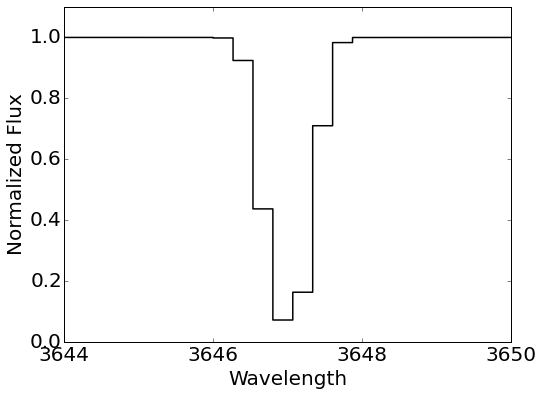

In [8]:
# Plot
plt_line(vmodel)

### Use self-generated wavelength

In [21]:
abslin.attrib['N'] = 17.5
abslin.attrib['b'] = 20.*u.km/u.s

In [22]:
wave = np.linspace(3644, 3650,100)*u.AA

In [23]:
vmodel2 = abslin.generate_voigt(wave=wave)

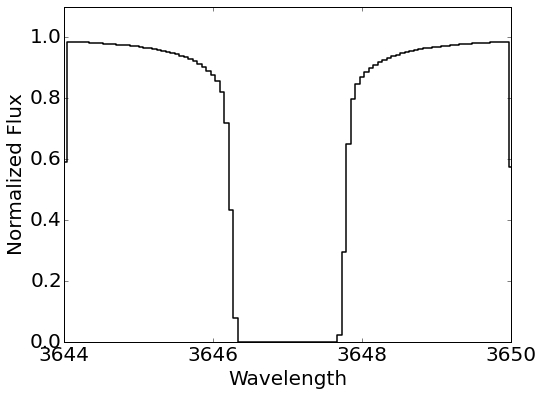

In [24]:
plt_line(vmodel2)

## Multiple Lines

In [29]:
abslin2 = AbsLine('DI 1215')
abslin2.attrib['N'] = 13.  # log N
abslin2.attrib['b'] = 15.*u.km/u.s
abslin2.attrib['z'] = 2.0

In [26]:
vmodel3 = lav.voigt_model(wave,[abslin,abslin2])

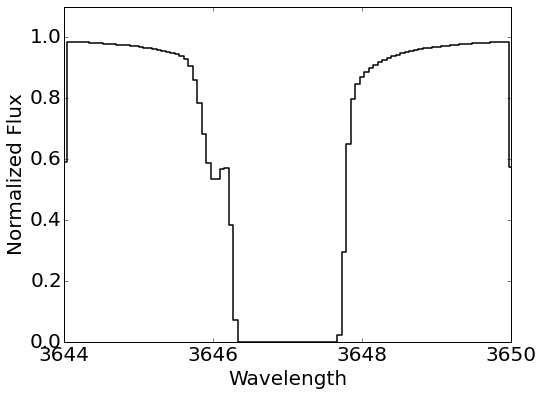

In [27]:
plt_line(vmodel3)

## $\tau$ Profiles

In [33]:
reload(lav)
tau = lav.voigt_model(wave,abslin,flg_ret=2)

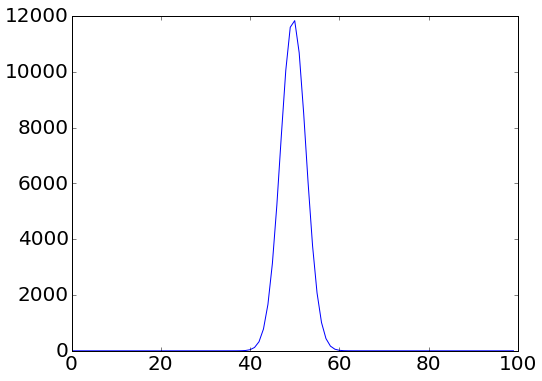

In [34]:
xdb.xplot(tau)